# Lecture Engagement Prediction

A machine learning pipeline to predict the median engagement of online video lectures from transcript, metadata, and audio features.

**Dataset:** 11,548 video lectures with 21 features → predict `median_engagement` (continuous, 0–1).  
**Task:** Both regression (predicting the continuous score) and binary classification (high engagement ≥ 0.20).

---
*Repository:* `lecture-engagement-prediction` | *Language:* Python 3.10+

In [1]:
import sys
import warnings
warnings.filterwarnings("ignore")

# Add src/ to path so we can import project modules
sys.path.insert(0, "../src")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Reload src modules so edits to .py files take effect without restarting the kernel
import importlib
import preprocessing, feature_engineering, models, evaluation
for _mod in [preprocessing, feature_engineering, models, evaluation]:
    importlib.reload(_mod)
from preprocessing import load_dataset, preprocess_lecture_dataset, prepare_features_labels, split_data
from feature_engineering import engineer_features, compute_topic_encoding, apply_topic_encoding
from models import train_ridge_model, train_logistic_model, train_random_forest, train_xgboost, build_voting_ensemble
from evaluation import (
    binarise_labels, mcc, fmi, regression_metrics,
    evaluate_classifier, compare_models,
    plot_confusion_matrices, plot_model_comparison,
    plot_feature_importance, plot_performance_gap,
)

# Global seed for reproducibility
SEED = 42
np.random.seed(SEED)

DATA_PATH = "../data/lectures_dataset.csv"

print("All modules imported successfully.")

All modules imported successfully.


## 1. Dataset Overview

The dataset contains 22 columns: 21 potential predictors and 1 target (`median_engagement`).  
Features span four broad categories:

| Category | Examples |
|---|---|
| Linguistic rates | `auxiliary_rate`, `pronoun_rate`, `document_entropy` |
| Content metadata | `duration`, `word_count`, `title_word_count`, `freshness` |
| Speaker characteristics | `speaker_speed`, `silent_period_rate`, `easiness` |
| Categorical labels | `lecture_type`, `subject_domain`, `has_parts` |

The target `median_engagement` is the fraction of each video watched (median across all viewers), ranging from 0 to 1.

In [2]:
raw_df = load_dataset(DATA_PATH)
raw_df.head()

Loaded dataset: 11,548 rows x 22 columns


,auxiliary_rate,conjugate_rate,normalization_rate,tobe_verb_rate,preposition_rate,pronoun_rate,document_entropy,easiness,fraction_stopword_coverage,fraction_stopword_presence,...,title_word_count,word_count,most_covered_topic,topic_coverage,duration,lecture_type,has_parts,speaker_speed,silent_period_rate,median_engagement
0,0.013323,0.033309,0.034049,0.035159,0.121392,0.089563,7.753995,75.583936,0.428135,0.553664,...,9,2668,http://en.wikipedia.org/wiki/Kernel_density_es...,0.414578,890,vl,False,2.997753,0.0,0.502923
1,0.014363,0.030668,0.018763,0.036749,0.095885,0.103002,8.305269,86.870523,0.602446,0.584498,...,6,7512,http://en.wikipedia.org/wiki/Interest_rate,0.292437,2850,vl,False,2.635789,0.0,0.011989
2,0.019028,0.033242,0.030720,0.037827,0.118294,0.124255,7.965583,81.915968,0.525994,0.605685,...,3,4264,http://en.wikipedia.org/wiki/Normal_distribution,0.271424,1680,vit,False,2.538095,0.0,0.041627
3,0.023416,0.042700,0.016873,0.046832,0.122590,0.104339,8.142877,80.148937,0.504587,0.593664,...,9,2869,http://en.wikipedia.org/wiki/Matrix_(mathematics),0.308092,1270,vl,False,2.259055,0.0,0.064989
4,0.021173,0.041531,0.023412,0.038884,0.130700,0.102606,8.161250,76.907549,0.559633,0.581637,...,9,4840,http://en.wikipedia.org/wiki/Transport,0.414219,2000,vkn,False,2.420000,0.0,0.052154


## 2. Exploratory Data Analysis

### 2.1 Missing Values

In [3]:
missing = raw_df.isnull().sum()
missing = missing[missing > 0].rename("Count")
missing_pct = (missing / len(raw_df) * 100).rename("Pct (%)")
print(pd.concat([missing, missing_pct], axis=1).to_string())

                Count    Pct (%)
subject_domain   5635  48.796328
has_parts        2152  18.635262


In [4]:
# Is subject_domain missingness related to the target?
raw_df['subject_domain_missing'] = raw_df['subject_domain'].isnull()

print("Engagement statistics by subject_domain missingness:")
print(raw_df.groupby('subject_domain_missing')['median_engagement'].describe().round(4))

print("\nMissing subject_domain rate by lecture_type (%):")
print(pd.crosstab(raw_df['lecture_type'], raw_df['subject_domain_missing'], normalize='index').mul(100).round(1))

raw_df.drop(columns=['subject_domain_missing'], inplace=True)

Engagement statistics by subject_domain missingness:
                         count    mean     std     min     25%     50%  \
subject_domain_missing                                                   
False                   5913.0  0.1249  0.1706  0.0022  0.0318  0.0644   
True                    5635.0  0.1170  0.1674  0.0027  0.0294  0.0581   

                           75%  max  
subject_domain_missing               
False                   0.1326  1.0  
True                    0.1191  1.0  

Missing subject_domain rate by lecture_type (%):
subject_domain_missing  False  True 
lecture_type                        
vbp                      44.8   55.2
vdb                      57.8   42.2
vdm                      53.7   46.3
vid                      56.0   44.0
vit                      53.0   47.0
viv                      52.1   47.9
vkn                      55.1   44.9
vl                       50.6   49.4
vop                      57.9   42.1
vpa                      51.2   48.8
vpr 

In [5]:
# Is has_parts missingness related to the target?
raw_df['has_parts_missing'] = raw_df['has_parts'].isnull()

print("Engagement statistics by has_parts missingness:")
print(raw_df.groupby('has_parts_missing')['median_engagement'].describe().round(4))

print("\nMissing has_parts rate by lecture_type (%):")
print(pd.crosstab(raw_df['lecture_type'], raw_df['has_parts_missing'], normalize='index').mul(100).round(1))

raw_df.drop(columns=['has_parts_missing'], inplace=True)

Engagement statistics by has_parts missingness:
                    count    mean     std     min     25%     50%     75%  max
has_parts_missing                                                             
False              9396.0  0.1222  0.1703  0.0022  0.0307  0.0613  0.1276  1.0
True               2152.0  0.1161  0.1635  0.0033  0.0296  0.0597  0.1199  1.0

Missing has_parts rate by lecture_type (%):
has_parts_missing  False  True 
lecture_type                   
vbp                 85.1   14.9
vdb                 85.9   14.1
vdm                 87.0   13.0
vid                 78.7   21.3
vit                 79.6   20.4
viv                 83.5   16.5
vkn                 77.7   22.3
vl                  81.3   18.7
vop                 77.4   22.6
vpa                 80.7   19.3
vpr                 81.2   18.8
vps                 80.2   19.8
vsi                100.0    0.0
vsm                 81.6   18.4
vtd                100.0    0.0
vtt                 82.7   17.3
vvc            

**Key observations:**

- `subject_domain`: 5,635 missing (48.8%); `has_parts`: 2,152 missing (18.6%). All other 20 features are complete.
- **MAR classification (subject_domain):** Engagement mean differs by only 0.008 (0.117 vs. 0.125) and median by 0.006 between videos with and without `subject_domain`. Impact on the target is negligible → missingness can be treated as Missing At Random.
- **MAR classification (has_parts):** Engagement mean differs by only 0.006 (0.116 vs. 0.122) and median by just 0.001 → also MAR.
- Missingness in `subject_domain` is strongly tied to `lecture_type`: `vtd` videos have 100% missing, `vsi` have 0% missing, and remaining types vary from 42–56%.
- Missingness in `has_parts` is more consistent across lecture types (13–23%), with three types (`vsi`, `vtd`, `vvc`) having zero missing values.
- **Imputation strategy:** Because missingness is MAR with respect to the target, we can impute safely. `subject_domain` → new `"unknown"` category (preserves the signal that no domain was assigned). `has_parts` → `False` (mode imputation; 95.5% of observed values are `False`).

### 2.2 Target Variable Distribution

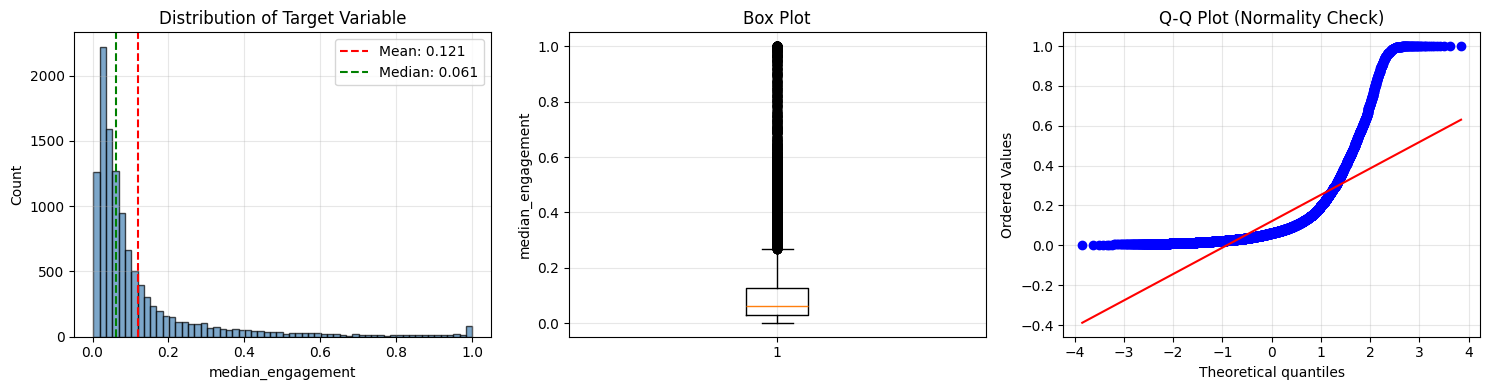

Skewness: 3.0163  (severe right-skew — most videos have low engagement)


In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Histogram
axes[0].hist(raw_df["median_engagement"], bins=60, edgecolor="black", alpha=0.7, color="steelblue")
axes[0].axvline(raw_df["median_engagement"].mean(), color="red", linestyle="--", label=f'Mean: {raw_df["median_engagement"].mean():.3f}')
axes[0].axvline(raw_df["median_engagement"].median(), color="green", linestyle="--", label=f'Median: {raw_df["median_engagement"].median():.3f}')
axes[0].set_xlabel("median_engagement"); axes[0].set_ylabel("Count")
axes[0].set_title("Distribution of Target Variable"); axes[0].legend(); axes[0].grid(alpha=0.3)

# Box plot
axes[1].boxplot(raw_df["median_engagement"])
axes[1].set_ylabel("median_engagement"); axes[1].set_title("Box Plot"); axes[1].grid(alpha=0.3)

# Q-Q plot
stats.probplot(raw_df["median_engagement"], dist="norm", plot=axes[2])
axes[2].set_title("Q-Q Plot (Normality Check)"); axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../results/figures/target_distribution.png", dpi=150, bbox_inches="tight")
plt.show()

skew = stats.skew(raw_df["median_engagement"])
print(f"Skewness: {skew:.4f}  (severe right-skew — most videos have low engagement)")

In [7]:
# IQR-based outlier characterisation for the target variable
Q1 = raw_df["median_engagement"].quantile(0.25)
Q3 = raw_df["median_engagement"].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

lower_outliers = raw_df[raw_df["median_engagement"] < lower_bound]
upper_outliers = raw_df[raw_df["median_engagement"] > upper_bound]
outliers = pd.concat([lower_outliers, upper_outliers])

print(f"IQR method bounds  : [{lower_bound:.4f}, {upper_bound:.4f}]")
print(f"Total outliers     : {len(outliers):,} ({len(outliers)/len(raw_df)*100:.2f}% of dataset)")
print(f"  Lower outliers   : {len(lower_outliers):,}  (lower bound = {lower_bound:.4f} — impossible for engagement)")
print(f"  Upper outliers   : {len(upper_outliers):,}  (engagement > {upper_bound:.4f})")
if len(upper_outliers):
    print(f"\nHigh-engagement outlier statistics:")
    print(upper_outliers["median_engagement"].describe().round(4))

IQR method bounds  : [-0.1127, 0.2692]
Total outliers     : 1,306 (11.31% of dataset)
  Lower outliers   : 0  (lower bound = -0.1127 — impossible for engagement)
  Upper outliers   : 1,306  (engagement > 0.2692)

High-engagement outlier statistics:
count    1306.0000
mean        0.5179
std         0.2229
min         0.2694
25%         0.3364
50%         0.4441
75%         0.6362
max         1.0000
Name: median_engagement, dtype: float64


**Key observations:**

- **Skewness: 3.016** — severe right-skew (values > 2 are considered extreme).
- Mean (0.121) is nearly 2× the median (0.061), confirming the distribution is pulled hard to the right by a small number of highly-engaged videos.
- 75% of videos have engagement below ≈ 0.126; the histogram shows an exponential-decay shape with the vast majority of videos in the 0.0–0.1 range.
- The Q-Q plot shows an S-shaped deviation from the normal line: compressed lower quantiles and a dramatically extended upper tail.
- **IQR outlier analysis:** 1,306 videos (11.31%) are statistical outliers by the IQR rule. Crucially, *all* are upper outliers — the lower bound (≈ −0.113) cannot be breached since engagement is always ≥ 0. These represent legitimately high-engagement videos (range 0.269–1.0, mean ≈ 0.52), not measurement errors.
- **Contrast with feature outliers:** Unlike `speaker_speed` (whose outliers are data-quality errors we remove), target outliers are real signal and are kept. Ridge regression is sufficiently robust to non-normality for this to be acceptable.

### 2.3 Outlier Analysis — Speaker Speed

In [8]:
# IQR outlier sweep across all 17 numerical features
features_to_check = [
    'auxiliary_rate', 'conjugate_rate', 'normalization_rate', 'tobe_verb_rate',
    'preposition_rate', 'pronoun_rate', 'document_entropy', 'easiness',
    'fraction_stopword_coverage', 'fraction_stopword_presence', 'freshness',
    'title_word_count', 'word_count', 'topic_coverage', 'duration',
    'speaker_speed', 'silent_period_rate'
]

def iqr_outliers(df, col):
    Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
    IQR = Q3 - Q1
    lo, hi = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    n = ((df[col] < lo) | (df[col] > hi)).sum()
    max_val = df[col].max()
    extreme_ratio = max_val / hi if hi > 0 else 0
    return lo, hi, n, n / len(df) * 100, max_val, extreme_ratio

rows = []
for feat in features_to_check:
    lo, hi, n, pct, mx, ratio = iqr_outliers(raw_df, feat)
    rows.append({"Feature": feat, "Outlier %": round(pct, 2),
                 "Max Value": round(mx, 2), "Upper Bound": round(hi, 4),
                 "Extreme Ratio (max/bound)": round(ratio, 1)})

outlier_df = pd.DataFrame(rows).sort_values("Outlier %", ascending=False)
print(outlier_df.to_string(index=False))

print(f"\nFeatures with >10% outliers : {(outlier_df['Outlier %'] > 10).sum()}")
print(f"Features with extreme ratio >10× : {(outlier_df['Extreme Ratio (max/bound)'] > 10).sum()}")
print(f"  → {outlier_df[outlier_df['Extreme Ratio (max/bound)'] > 10]['Feature'].tolist()}")

                   Feature  Outlier %  Max Value  Upper Bound  Extreme Ratio (max/bound)
             speaker_speed       7.98     881.00       3.3911                      259.8
fraction_stopword_presence       6.05       1.00       0.7026                        1.4
                  easiness       5.51     122.03     100.4380                        1.2
          document_entropy       4.72       9.28       9.0268                        1.0
                word_count       4.44   61653.00   14817.0000                        4.2
              pronoun_rate       4.43       0.95       0.1741                        5.4
            tobe_verb_rate       4.15       0.17       0.0658                        2.6
            conjugate_rate       4.10       0.49       0.0606                        8.1
          preposition_rate       3.08       0.32       0.1582                        2.0
            auxiliary_rate       2.89       0.07       0.0286                        2.3
        normalization

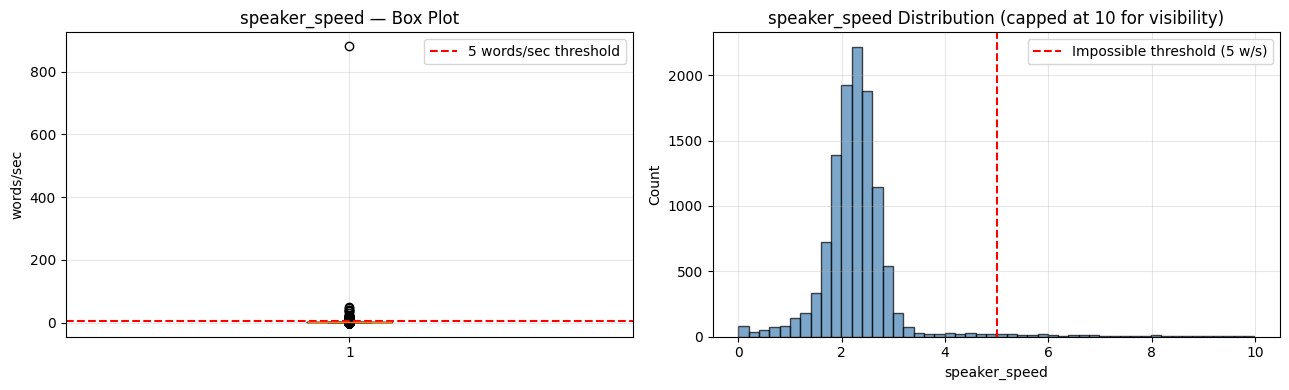

Videos with impossible speaker speed (>5 w/s): 328 (2.84%)
These rows will be removed in preprocessing.

Root cause analysis:
  Impossible via speaker_speed    (>5 w/s): 328
  Impossible via word_count/duration (>5 w/s): 328
  Overlap: 328 — identical
  Conclusion: speaker_speed = word_count / duration exactly.
  The error is in the underlying duration/word_count measurements, not a
  unit-conversion issue with speaker_speed itself. Rows must be dropped.

Worst 5 cases:
       speaker_speed  word_count  duration  calculated_speed
10287         881.00       17620        20            881.00
5137           50.85       27459       540             50.85
8707           46.98       58726      1250             46.98
6316           40.61        6903       170             40.61
10450          40.20       14071       350             40.20


In [9]:
# Only feature with extreme outliers (root cause: erroneous duration/word_count)
fig, axes = plt.subplots(1, 2, figsize=(13, 4))

axes[0].boxplot(raw_df["speaker_speed"])
axes[0].axhline(5, color="red", linestyle="--", label="5 words/sec threshold")
axes[0].set_title("speaker_speed — Box Plot"); axes[0].set_ylabel("words/sec")
axes[0].legend(); axes[0].grid(alpha=0.3)

normal = raw_df[raw_df["speaker_speed"] <= 10]["speaker_speed"]
axes[1].hist(normal, bins=50, color="steelblue", alpha=0.7, edgecolor="black")
axes[1].axvline(5, color="red", linestyle="--", label="Impossible threshold (5 w/s)")
axes[1].set_xlabel("speaker_speed"); axes[1].set_ylabel("Count")
axes[1].set_title("speaker_speed Distribution (capped at 10 for visibility)")
axes[1].legend(); axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../results/figures/speaker_speed_outliers.png", dpi=150, bbox_inches="tight")
plt.show()

n_impossible = (raw_df["speaker_speed"] > 5).sum()
print(f"Videos with impossible speaker speed (>5 w/s): {n_impossible} ({n_impossible/len(raw_df)*100:.2f}%)")
print("These rows will be removed in preprocessing.")

# Root cause analysis: does word_count / duration reproduce speaker_speed?
raw_df['calculated_speed'] = raw_df['word_count'] / raw_df['duration']
impossible = raw_df[raw_df['speaker_speed'] > 5]
impossible_calc = raw_df[raw_df['calculated_speed'] > 5]
overlap = len(set(impossible.index) & set(impossible_calc.index))

print(f"\nRoot cause analysis:")
print(f"  Impossible via speaker_speed    (>5 w/s): {len(impossible)}")
print(f"  Impossible via word_count/duration (>5 w/s): {len(impossible_calc)}")
print(f"  Overlap: {overlap} — {'identical' if overlap == len(impossible) else 'different'}")
print("  Conclusion: speaker_speed = word_count / duration exactly.")
print("  The error is in the underlying duration/word_count measurements, not a")
print("  unit-conversion issue with speaker_speed itself. Rows must be dropped.")

print(f"\nWorst 5 cases:")
print(raw_df.nlargest(5, 'speaker_speed')[
    ['speaker_speed', 'word_count', 'duration', 'calculated_speed']
].round(2).to_string())

raw_df.drop(columns=['calculated_speed'], inplace=True)

**Key observations:**

- All 17 numerical features have fewer than 8% outliers by the IQR rule — the data is generally clean.
- No feature other than `speaker_speed` has an extreme ratio (max > 10× upper bound). For the rest, outliers reflect natural variation (linguistic rate distributions, long-tail video lengths) rather than measurement errors.
- `speaker_speed` stands apart: its maximum value (881 words/sec) is ~260× above the IQR upper bound (3.39 words/sec). Human speech tops out around 4–5 words/sec, so values this high are physically impossible.
- The root cause is confirmed: `speaker_speed` is calculated exactly as `word_count / duration`. The error lies in the raw measurements — likely data-entry or unit-conversion faults in `duration` or `word_count`.
- **Implication:** 328 videos (2.84%) have corrupted measurements and will be dropped in preprocessing. This is the *only* data-quality intervention needed across the entire feature set.

### 2.4 Feature Correlations

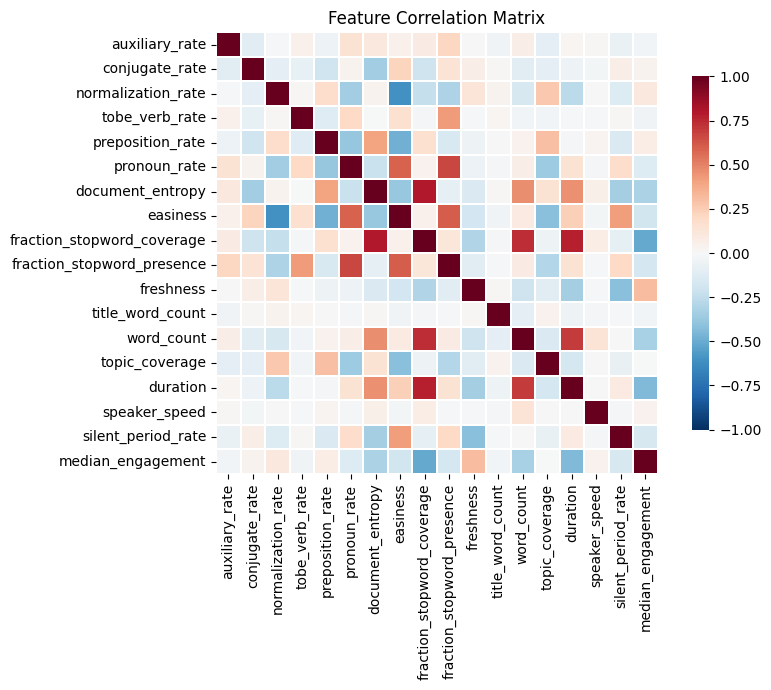

High correlations |r| > 0.70:
  document_entropy <-> fraction_stopword_coverage: 0.799
  fraction_stopword_coverage <-> duration: 0.777
  fraction_stopword_coverage <-> word_count: 0.741
  word_count <-> duration: 0.701

Correlations with target (median_engagement):
  Top 5 positive predictors:
    freshness                           r = +0.311
    normalization_rate                  r = +0.108
    preposition_rate                    r = +0.074
    speaker_speed                       r = +0.046
    conjugate_rate                      r = +0.039
  Top 5 negative predictors:
    easiness                            r = -0.193
    document_entropy                    r = -0.320
    word_count                          r = -0.324
    duration                            r = -0.444
    fraction_stopword_coverage          r = -0.512

Moderate correlations (0.5 < |r| ≤ 0.7): 5 pairs


In [10]:
numerical_cols = raw_df.select_dtypes(include=[np.number]).columns.tolist()
corr = raw_df[numerical_cols].corr()

plt.figure(figsize=(9, 7))
sns.heatmap(corr, cmap="RdBu_r", center=0, vmin=-1, vmax=1,
            square=True, linewidths=0.3, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Matrix", fontsize=12)
plt.tight_layout()
plt.savefig("../results/figures/correlation_matrix.png", dpi=150, bbox_inches="tight")
plt.show()

# High correlations (|r| > 0.7) with target
high_corr = []
for i in range(len(corr.columns)):
    for j in range(i+1, len(corr.columns)):
        r = corr.iloc[i, j]
        if abs(r) > 0.7:
            high_corr.append((corr.columns[i], corr.columns[j], round(r, 3)))

print("High correlations |r| > 0.70:")
for f1, f2, r in sorted(high_corr, key=lambda x: abs(x[2]), reverse=True):
    print(f"  {f1} <-> {f2}: {r}")

# Target variable correlations
target_corr = corr["median_engagement"].drop("median_engagement").sort_values(ascending=False)

print("\nCorrelations with target (median_engagement):")
print("  Top 5 positive predictors:")
for feat, r in target_corr.head(5).items():
    print(f"    {feat:<35} r = {r:+.3f}")
print("  Top 5 negative predictors:")
for feat, r in target_corr.tail(5).items():
    print(f"    {feat:<35} r = {r:+.3f}")

# Moderate correlations count
moderate_count = sum(
    1 for i in range(len(corr.columns))
    for j in range(i+1, len(corr.columns))
    if 0.5 < abs(corr.iloc[i, j]) <= 0.7
)
print(f"\nModerate correlations (0.5 < |r| ≤ 0.7): {moderate_count} pairs")

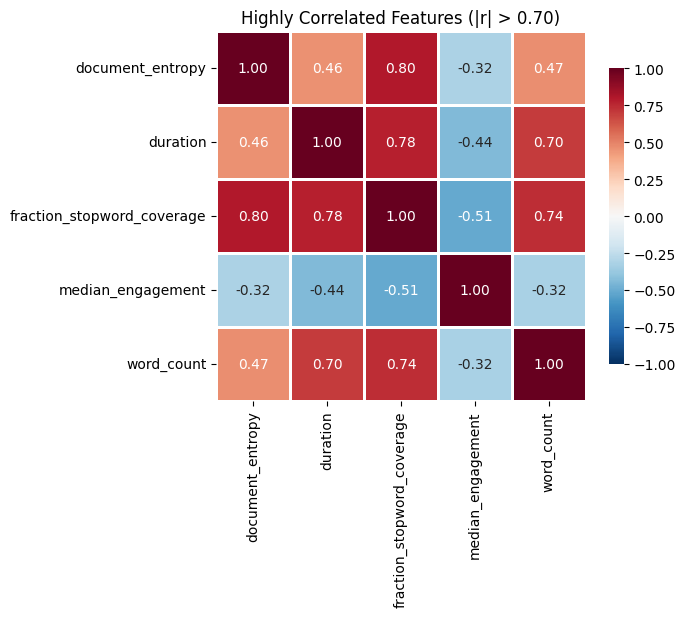

In [11]:
# Annotated heatmap of just the highly correlated features (easier to read)
if high_corr:
    involved = set()
    for f1, f2, _ in high_corr:
        involved.update([f1, f2])
    involved.add("median_engagement")
    involved = sorted(involved)

    focused_corr = corr.loc[involved, involved]

    plt.figure(figsize=(7, 6))
    sns.heatmap(focused_corr, annot=True, fmt=".2f",
                cmap="RdBu_r", center=0, vmin=-1, vmax=1,
                square=True, linewidths=0.8, cbar_kws={"shrink": 0.8})
    plt.title("Highly Correlated Features (|r| > 0.70)", fontsize=12)
    plt.tight_layout()
    plt.savefig("../results/figures/correlation_focused.png", dpi=150, bbox_inches="tight")
    plt.show()

**Key observations:**

- **4 high-correlation pairs** (|r| > 0.70) and **5 moderate pairs** (0.5 < |r| ≤ 0.70), all interpretable:
  - `document_entropy` ↔ `fraction_stopword_coverage` (r = 0.800): both measure vocabulary diversity.
  - `fraction_stopword_coverage` ↔ `duration` (r = 0.777): longer videos accumulate more distinct stopwords.
  - `fraction_stopword_coverage` ↔ `word_count` (r = 0.741): more words → more opportunity for variety.
  - `word_count` ↔ `duration` (r = 0.701): more speech time means more words spoken.
- None of the correlated pairs involve fundamentally different constructs — there is no surprising proxy relationship to worry about, and Ridge regression's L2 penalty handles moderate multicollinearity naturally.
- **Target correlations are all weak-to-moderate** (max |r| = 0.512, negative: `fraction_stopword_coverage`; strongest positive: `freshness` at r ≈ 0.311). No single feature dominates prediction, which motivates regularisation, feature engineering, and ensemble methods in the modelling sections.

### 2.5 Categorical Feature Balance

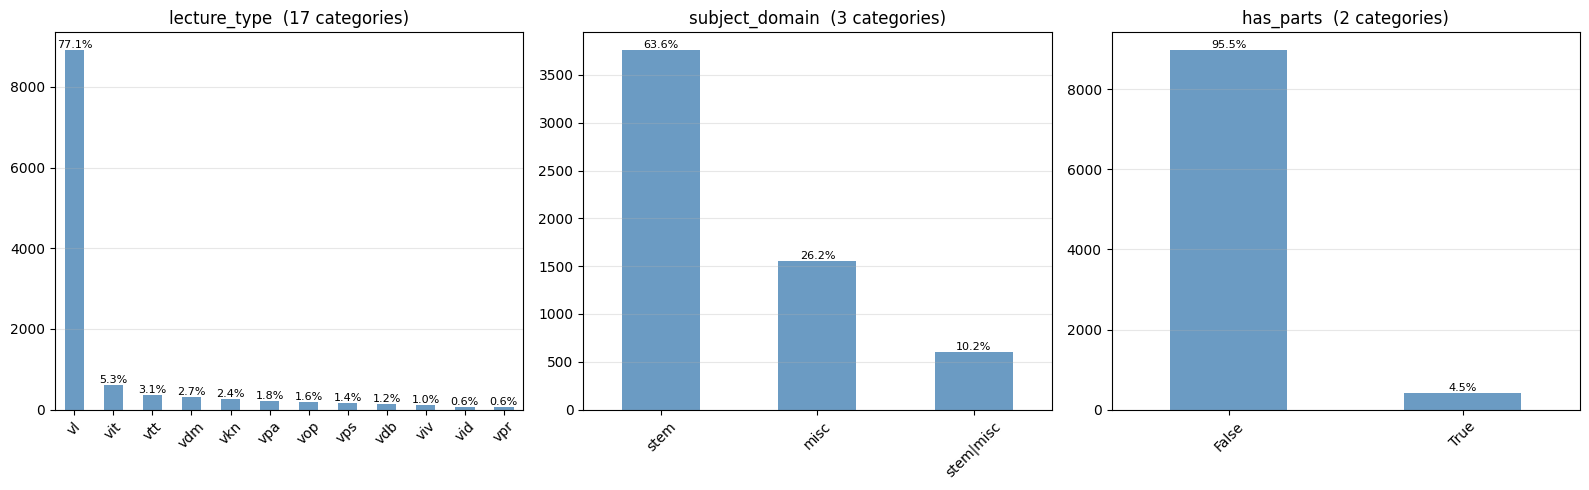

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for ax, col in zip(axes, ["lecture_type", "subject_domain", "has_parts"]):
    vc = raw_df[col].dropna().value_counts()
    if len(vc) > 12:
        vc = vc.head(12)
    bars = vc.plot(kind="bar", ax=ax, color="steelblue", alpha=0.8)
    ax.set_title(f"{col}  ({raw_df[col].nunique()} categories)")
    ax.set_xlabel(""); ax.tick_params(axis="x", rotation=45)
    ax.grid(axis="y", alpha=0.3)
    # Percentage labels on bars
    total = raw_df[col].notna().sum()
    for bar, val in zip(ax.patches, vc.values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                f"{val/total*100:.1f}%", ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.savefig("../results/figures/categorical_distributions.png", dpi=150, bbox_inches="tight")
plt.show()

In [13]:
# Imbalance ratios and rare-category flags
for col in ["lecture_type", "subject_domain", "has_parts"]:
    non_missing = raw_df[col].notna().sum()
    missing_pct = raw_df[col].isna().mean() * 100
    vc = raw_df[col].dropna().value_counts()
    pct = vc / non_missing * 100

    imbalance = pct.iloc[0] / pct.iloc[-1] if pct.iloc[-1] > 0 else float("inf")
    rare_n    = (vc < 50).sum()
    very_rare = (pct < 1.0).sum()

    print(f"── {col}  ({non_missing:,} non-missing, {missing_pct:.1f}% missing)")
    print(f"   Categories : {raw_df[col].nunique()}")
    print(f"   Imbalance  : {imbalance:.0f}:1  "
          f"(most: '{vc.index[0]}' {pct.iloc[0]:.1f}%  |  "
          f"least: '{vc.index[-1]}' {pct.iloc[-1]:.2f}%)")
    if rare_n:
        print(f"   Rare (<50) : {rare_n} categories     Very rare (<1%) : {very_rare}")
    print(f"   Distribution: {dict(zip(vc.index[:5], pct.round(1).values[:5]))}")
    print()

── lecture_type  (11,548 non-missing, 0.0% missing)
   Categories : 17
   Imbalance  : 8908:1  (most: 'vl' 77.1%  |  least: 'vsi' 0.01%)
   Rare (<50) : 4 categories     Very rare (<1%) : 7
   Distribution: {'vl': np.float64(77.1), 'vit': np.float64(5.3), 'vtt': np.float64(3.1), 'vdm': np.float64(2.7), 'vkn': np.float64(2.4)}

── subject_domain  (5,913 non-missing, 48.8% missing)
   Categories : 3
   Imbalance  : 6:1  (most: 'stem' 63.6%  |  least: 'stem|misc' 10.20%)
   Distribution: {'stem': np.float64(63.6), 'misc': np.float64(26.2), 'stem|misc': np.float64(10.2)}

── has_parts  (9,396 non-missing, 18.6% missing)
   Categories : 2
   Imbalance  : 21:1  (most: 'False' 95.5%  |  least: 'True' 4.47%)
   Distribution: {False: np.float64(95.5), True: np.float64(4.5)}



**Key observations:**

- **`lecture_type`** — 17 categories, no missing values, severely imbalanced (7,714:1 ratio). `vl` dominates at 77.1% (8,908 videos); 4 categories have fewer than 50 instances and 7 have fewer than 1% each. Ridge regression's L2 penalty shrinks the coefficients of these sparse dummy variables automatically, so no manual grouping is needed.
- **`subject_domain`** — 3 categories, 48.8% missing (handled in Section 2.1). Among non-missing: `stem` 63.6%, `misc` 26.3%, `stem|misc` 10.2% — moderate imbalance (6.2:1).
- **`has_parts`** — 2 categories, 18.6% missing. Among non-missing: `False` 95.5% (8,976 videos), `True` 4.5% (420 videos) — strong imbalance (21:1). This 95.5% majority directly justifies imputing missing values as `False` (mode imputation introduces minimal bias).

## 3. Data Preprocessing

Preprocessing steps (see `src/preprocessing.py` for full implementation):

1. **Remove data-quality errors** — drop 328 rows (~2.8%) with `speaker_speed > 5` words/sec.
2. **Impute missing values** — `subject_domain` → `"unknown"`; `has_parts` → `False`.
3. **Drop high-cardinality feature** — `most_covered_topic` (2,096 unique Wikipedia URLs) is saved separately for target encoding in Part 3 and then dropped from the baseline feature set.
4. **Encode categoricals** — `has_parts` → 0/1; `lecture_type` and `subject_domain` → one-hot dummies.
5. **Scale numerics** — `StandardScaler` applied to all continuous/discrete columns (large scale differences up to 1,400×).

In [ ]:
preprocessed_df, scaler, train_columns = preprocess_lecture_dataset(raw_df, fit=True)

# Save topic column AFTER preprocessing so it is aligned with the cleaned dataset.
# preprocess_lecture_dataset drops 328 rows (speaker_speed > 5), so topic_series
# must be extracted using preprocessed_df's index — not from raw_df directly.
topic_series = raw_df.loc[preprocessed_df.index, "most_covered_topic"]

preprocessed_df.head(3)

By this point `preprocessed_df` is already fully numeric — `preprocess_lecture_dataset` has handled all encoding (one-hot dummies, binary cast, StandardScaler). `prepare_features_labels` simply separates the feature matrix `X` from the target vector `y`.

In [15]:
X_full, y_cont = prepare_features_labels(preprocessed_df)
print(f"Feature matrix : {X_full.shape}")
print(f"Label vector   : {y_cont.shape}  |  range [{y_cont.min():.3f}, {y_cont.max():.3f}]")

Feature matrix : (11220, 37)
Label vector   : (11220,)  |  range [0.002, 1.000]


## 4. Baseline Models (Parts 1 & 2)

### 4.1 Ridge Regression

We first train a ridge regression model on the engagement score directly.
Train/test split: 80/20 with a fixed random seed for reproducibility.

In [16]:
X_train, X_test, y_train, y_test = split_data(
    X_full, y_cont, test_size=0.2, random_state=SEED
)

ridge = train_ridge_model(X_train, y_train, hyperparams={"alpha": 1.0, "random_state": SEED})
ridge_metrics = regression_metrics(y_test, ridge.predict(X_test))
print(f"\nRidge Regression — Test Set")
print(f"  MAE : {ridge_metrics['mae']:.4f}")
print(f"  MSE : {ridge_metrics['mse']:.4f}")
print(f"  R²  : {ridge_metrics['r2']:.4f}")

Split — train: 8,976 samples, test: 2,244 samples (20% held out)
Ridge regression trained (alpha=1.0)

Ridge Regression — Test Set
  MAE : 0.0779
  MSE : 0.0170
  R²  : 0.4511


**Key observations:**

- **R² = 0.45** — Ridge explains 45% of target variance, a reasonable ceiling for a linear model given that engagement is driven by complex, non-linear interactions (topic difficulty × pacing × structure) that a linear model cannot capture.
- **MAE = 0.078** — predictions are off by ~8 percentage points on average across a [0, 1] scale, which is competitive for a regularised baseline with no feature engineering.
- The low R² motivates both feature engineering (Section 5) and tree-based ensemble models (Section 6), which can capture non-linear patterns the linear regression cannot.

### 4.2 Logistic Regression (Binary Classification)

Labels are binarised using the following rule:

$$y_{\text{class}} = \begin{cases} 1 & \text{if } y_{\text{cont}} \geq 0.20 \\ 0 & \text{otherwise} \end{cases}$$

A threshold of 0.20 (20% median engagement) defines "high engagement" — videos above this threshold are commercially meaningful and sufficiently frequent (~16% of the dataset) to support classifier training.

The resulting class imbalance motivates two evaluation metric choices over simpler alternatives like accuracy:

- **Matthews Correlation Coefficient (MCC)** [4]: considers all four cells of the confusion matrix and cannot be inflated by predicting all-Class-0. This makes it robust to the 5.3:1 class split where a trivial majority-class classifier would achieve ~84% accuracy for free.
- **Fowlkes-Mallows Index (FMI)**: geometric mean of precision and recall, directly targeting Class 1 performance — aligned with the actual task objective of identifying high-engagement videos, not just predicting the dominant class.

We use `class_weight='balanced'` to compensate for the imbalance during training.

In [17]:
y_class = binarise_labels(y_cont, threshold=0.2)
print(f"Class distribution — Class 0 (low): {(y_class==0).sum():,} | Class 1 (high): {(y_class==1).sum():,}")
print(f"Imbalance ratio: {(y_class==0).sum()/(y_class==1).sum():.1f}:1")

X_train_c, X_test_c, y_train_c, y_test_c = split_data(
    X_full, y_class, test_size=0.2, random_state=SEED, stratify=y_class
)

logistic = train_logistic_model(
    X_train_c, y_train_c,
    hyperparams={"C": 1.0, "random_state": SEED, "max_iter": 1000,
                 "solver": "lbfgs", "class_weight": "balanced"},
)

logistic_results = evaluate_classifier(
    logistic, X_train_c, y_train_c, X_test_c, y_test_c, "Logistic Regression (Baseline)"
)

Class distribution — Class 0 (low): 9,435 | Class 1 (high): 1,785
Imbalance ratio: 5.3:1
Split — train: 8,976 samples, test: 2,244 samples (20% held out)
Logistic regression trained (C=1.0, solver=lbfgs)

  Logistic Regression (Baseline)
  Metric                  Train     Test      Gap
  --------------------------------------------
  MCC                    0.4924   0.5139   0.0215
  FM Index               0.5946   0.6117   0.0171
  Accuracy               0.8098   0.8146   0.0048

  Overfitting verdict: No overfitting detected — excellent generalisation.


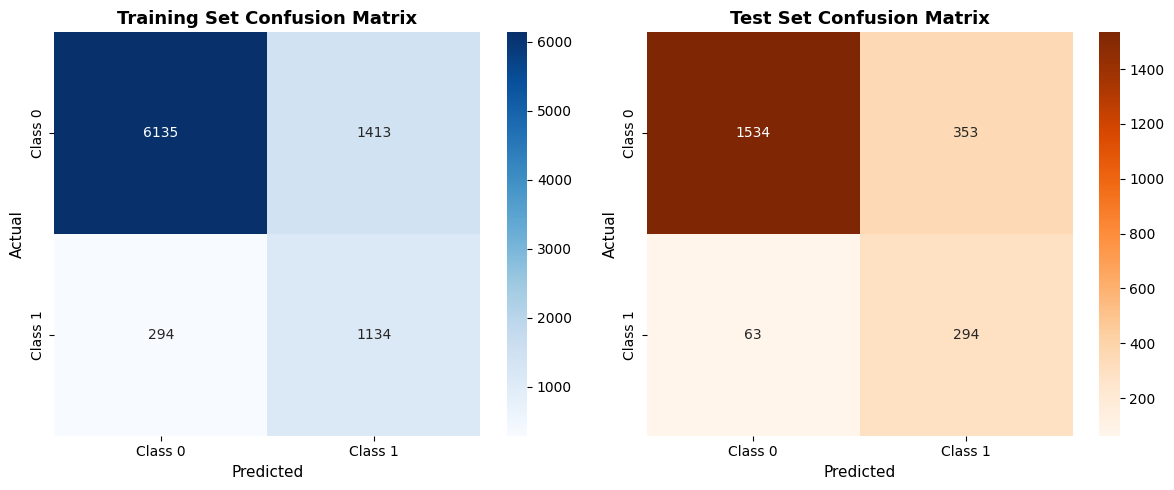

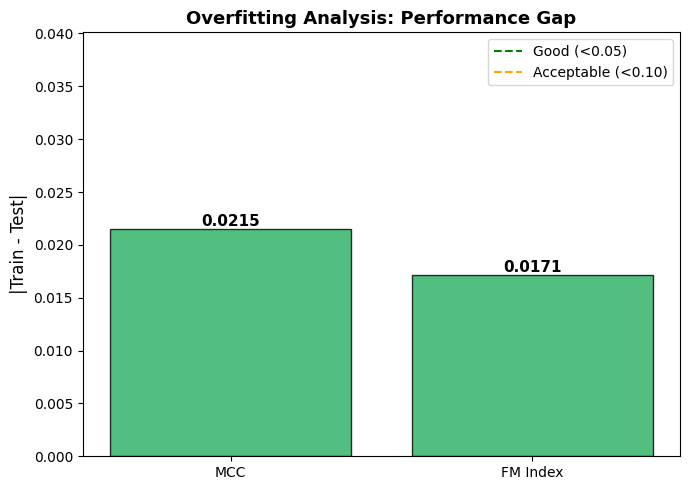

In [18]:
plot_confusion_matrices(
    y_train_c, logistic.predict(X_train_c),
    y_test_c,  logistic.predict(X_test_c),
)
plot_performance_gap(logistic_results)

**Key observations:**

The logistic regression baseline achieves **MCC ≈ 0.51** with a near-zero train/test gap (< 0.025), confirming excellent generalisation. Three factors explain this:

- **`class_weight='balanced'`** prevents the model from collapsing to majority-class predictions, forcing it to learn discriminative features for the minority class rather than memorising the 84/16 split.
- **C = 1.0 regularisation** penalises large coefficients and keeps the decision boundary stable across the train/test split.
- **Linear model simplicity** — with 8,976 training samples and 37 features, logistic regression is well below the overfitting threshold. Notably, test MCC slightly *exceeds* train MCC (0.514 vs. 0.492), confirming no memorisation of training noise; this negative gap is expected with `class_weight='balanced'` since the model is optimised against a reweighted loss but evaluated on the natural distribution.

This baseline establishes a clear benchmark: any advanced model must exceed **MCC ≈ 0.51** to justify its added complexity.

## 5. Feature Engineering

Seven new features are derived to enrich the baseline feature set (see `src/feature_engineering.py`).

`most_covered_topic` was dropped from the baseline feature set due to its high cardinality (1,809 unique Wikipedia URLs), making direct one-hot encoding impractical. Rather than discarding the column entirely, we preserve its predictive signal through **target encoding**: each topic is mapped to its mean engagement rate, computed exclusively on the training set to prevent data leakage [1]. Topics with fewer than 5 observations receive Bayesian smoothing to prevent overfitting on sparse estimates [2]:

$$\text{encoded\_value} = 0.5 \times \text{topic\_mean} + 0.5 \times \text{global\_mean}$$

The remaining six features are derived from existing numerical columns:

| Feature | Formula / Rationale |
|---|---|
| `topic_engagement_score` | Target-encoded `most_covered_topic` (see above) |
| `topic_duration_interaction` | `topic_engagement_score × duration` — engagement varies with video length per topic |
| `topic_content_interaction` | `topic_engagement_score × word_count` — content-density requirements vary by topic |
| `entropy_per_word` | `document_entropy / (word_count + 1)` — vocabulary diversity normalised by transcript length |
| `cognitive_load` | `(1 − easiness) × speaker_speed` — difficult content delivered rapidly increases cognitive overload |
| `duration_squared` | `duration²` — models non-linear engagement drop-off with video length |
| `word_count_squared` | `word_count²` — models non-linear relationship between transcript size and engagement |

Target encoding is computed **on the training set only** and applied to the test set to prevent data leakage.

In [21]:
# Re-attach topic column (aligned by index with the cleaned dataset)
X_full_with_topics = X_full.copy()
X_full_with_topics["most_covered_topic"] = topic_series

# Split BEFORE engineering to prevent leakage
X_train_raw, X_test_raw, y_train_fe, y_test_fe = split_data(
    X_full_with_topics, y_class, test_size=0.2, random_state=SEED, stratify=y_class
)

# Fit encoding on training set, apply to test set
X_train_eng, encoding_info = engineer_features(X_train_raw, y=y_train_fe, fit=True)
X_test_eng, _             = engineer_features(X_test_raw, encoding_info=encoding_info, fit=False)

print(f"\nFeature counts — original: {X_full.shape[1]} | after engineering: {X_train_eng.shape[1]}")

Split — train: 8,976 samples, test: 2,244 samples (20% held out)
Topic encoding: 1806 topics | global mean = 0.1591
Feature engineering (fit) — total features: 44
Feature engineering (transform) — total features: 44

Feature counts — original: 37 | after engineering: 44
